tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


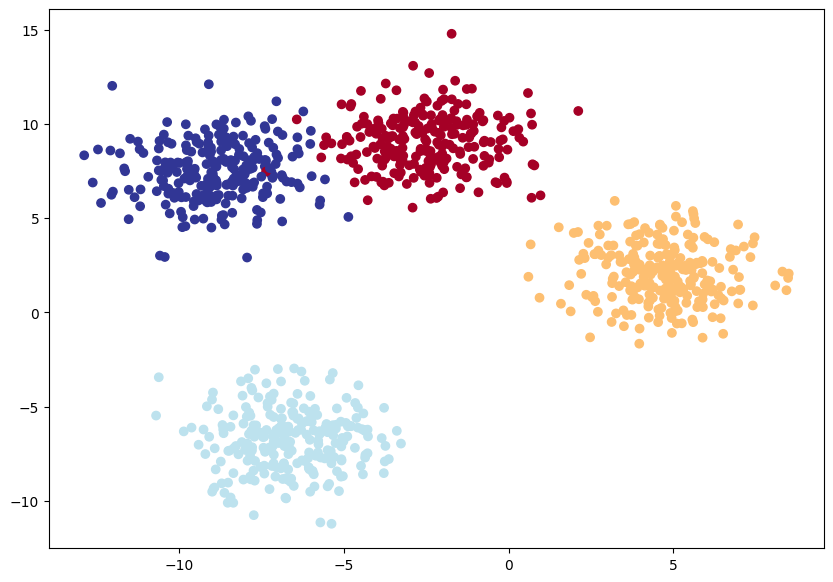

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [2]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_t = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_t

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [3]:
# Creating loss and optimizing strategies
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_t.parameters(),
                            lr=0.1)

In [4]:
model_t(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [5]:
#predictions lad
y_logits = model_t(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0487,  0.5468,  0.1754,  0.7621],
        [-0.1276, -0.0738,  0.3874,  0.4968],
        [-0.4002,  0.3196, -0.8907, -1.1979],
        [-0.1236,  0.5737, -0.1112,  0.3215],
        [ 0.0151,  0.2089,  0.6693,  1.2340]], grad_fn=<SliceBackward0>)
tensor([[0.1584, 0.2873, 0.1981, 0.3562],
        [0.1787, 0.1886, 0.2991, 0.3336],
        [0.2429, 0.4990, 0.1487, 0.1094],
        [0.1792, 0.3598, 0.1814, 0.2796],
        [0.1330, 0.1614, 0.2558, 0.4499]], grad_fn=<SliceBackward0>)


In [6]:
 torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [7]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1584, 0.2873, 0.1981, 0.3562], grad_fn=<SelectBackward0>)
tensor(3)


In [8]:
from sklearn.metrics import accuracy_score

# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_t.train()

    # 1. Forward pass
    y_logits = model_t(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_score(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_t.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_t(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_score(y_true=y_blob_test,
                             y_pred=test_pred)


    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.47442, Acc: 0.40% | Test Loss: 0.64412, Test Acc: 0.72%
Epoch: 10 | Loss: 0.18272, Acc: 0.99% | Test Loss: 0.16930, Test Acc: 0.99%
Epoch: 20 | Loss: 0.09560, Acc: 0.99% | Test Loss: 0.08740, Test Acc: 0.99%
Epoch: 30 | Loss: 0.06755, Acc: 0.99% | Test Loss: 0.05995, Test Acc: 0.99%
Epoch: 40 | Loss: 0.05444, Acc: 0.99% | Test Loss: 0.04674, Test Acc: 0.99%
Epoch: 50 | Loss: 0.04705, Acc: 0.99% | Test Loss: 0.03912, Test Acc: 0.99%
Epoch: 60 | Loss: 0.04236, Acc: 0.99% | Test Loss: 0.03422, Test Acc: 0.99%
Epoch: 70 | Loss: 0.03916, Acc: 0.99% | Test Loss: 0.03081, Test Acc: 0.99%
Epoch: 80 | Loss: 0.03685, Acc: 0.99% | Test Loss: 0.02832, Test Acc: 0.99%
Epoch: 90 | Loss: 0.03512, Acc: 0.99% | Test Loss: 0.02642, Test Acc: 0.99%


In [9]:
# Making predictions for the trained classification
model_t.eval()
with torch.inference_mode():
    y_logits = model_t(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  8.7648,  14.0237,  -9.5939,  -4.3104],
        [  2.9410, -11.7146,   1.2503,   8.5554],
        [-13.9890, -18.6814,  13.7018,   5.4681],
        [  4.0128,   9.4864,  -5.3733,  -3.6364],
        [ 12.4173,   7.7124, -10.0838,   1.0183],
        [  2.9345, -14.8179,   2.1266,  10.4042],
        [-13.6210, -15.2054,  12.4967,   3.5514],
        [  9.6185,   2.4814,  -6.8787,   2.9420],
        [-15.6083, -24.8043,  16.4265,   8.4287],
        [ 10.4453,   4.3280,  -7.9102,   2.1940]])

In [10]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_score(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 0.995%


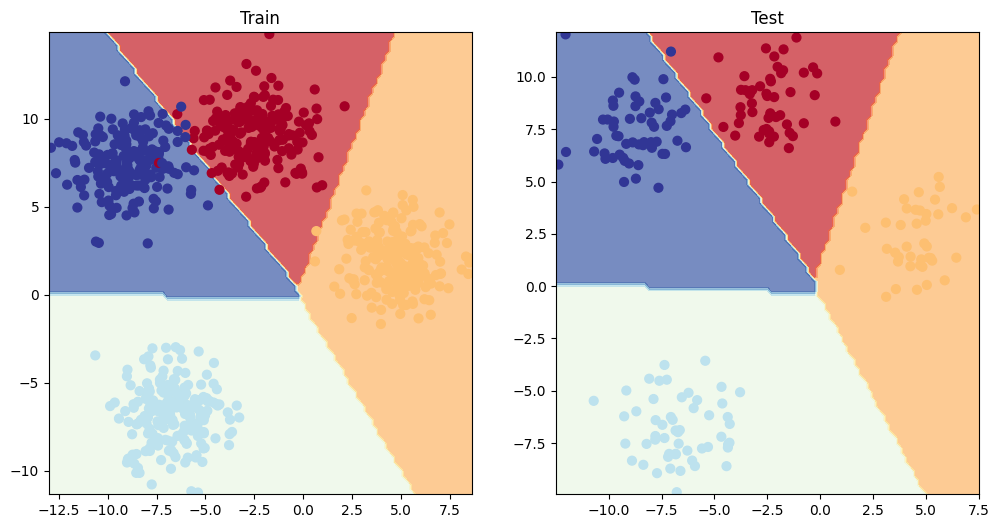

In [24]:
import requests
from pathlib import Path
from helper_functions import plot_predictions, plot_decision_boundary
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
  f.write(request.content)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_t, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_t, X_blob_test, y_blob_test)